# Notebook for analyze the gene set similarity with hypergeometric test

In [2]:
%run hypergeometric_GO.py --input_file data/GO_term_analysis/simrank_LLM_processed_selected_1000_go_terms.tsv --topn 3 --output_file data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv

100%|██████████| 1000/1000 [00:06<00:00, 163.94it/s]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from glob import glob
import re
from scipy.stats import wilcoxon, mannwhitneyu

# Set default configuration for all plots
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.titlesize'] = 7
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25
plt.rcParams["axes.unicode_minus"] = True
plt.figsize = (2,2)    

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd 
df = pd.read_csv('data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')

In [4]:
df.columns

Index(['GO', 'Genes', 'Gene_Count', 'Term_Description', 'gpt_4_default Name',
       'gpt_4_default Analysis', 'gpt_4_default Score',
       'gpt_4_default Score Bin', 'LLM_name_GO_term_sim', 'sim_rank',
       'true_GO_term_sim_percentile', 'random_GO_name', 'random_go_llm_sim',
       'random_sim_rank', 'random_sim_percentile', 'top_3_hits', 'top_3_sim',
       'pvals', 'adj_pvals', 'random_pvals', 'random_adj_pvals', 'JI',
       'random JI'],
      dtype='object')

In [5]:
def genes_coverage(genes, all_genes):
    return len(set(genes).intersection(set(all_genes))) / len(genes)


In [5]:
# number of terms that the best match term is the query term 
exact_match = 0
match_in_top_3 = 0
for i, row in df.iterrows():
    if row['Term_Description'] in row['top_3_hits'].split('|'):
        match_in_top_3 += 1
        if row['Term_Description'] == row['top_3_hits'].split('|')[0]:
            exact_match += 1
print('Exact match: ', exact_match) 
print('Match in top 3: ', match_in_top_3)

Exact match:  33
Match in top 3:  64


## calculate the coverage of broader concept 
in the cases where GO names are not semantically similar GPT 4 name

Calculate if the best matching name is associated to a term that is more general concept

In [5]:
from tqdm import tqdm
import  pandas as pd
import numpy as np


def genes_coverage(genes, all_genes):
    return len(set(genes).intersection(set(all_genes))) / len(genes)

df = pd.read_csv('data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')
df.set_index('GO', inplace=True)
all_go = pd.read_csv('data/go_terms.csv', index_col=0)

# filter the list by ranking the percentile and keep terms with true_GO_term_sim_percentile < 0.95

df_sorted = df.sort_values(by='true_GO_term_sim_percentile', ascending=True)
df_filtered = df_sorted[df_sorted['true_GO_term_sim_percentile'] < 0.95]

# because System of unrelated proteins will not have a best name that covers>50% of the genes
df_filtered = df_filtered[df_filtered['gpt_4_default Name']!= 'System of unrelated proteins']
print(df_filtered.shape)
new_df = df_filtered.loc[:,['Genes', 'Gene_Count', 'Term_Description','gpt_4_default Name',
       'gpt_4_default Analysis', 'gpt_4_default Score','gpt_4_default Score Bin', 'LLM_name_GO_term_sim','top_3_hits']]

new_df['covered_by_best_match'] = False

genes_coverage_list = []
genes_overlap_list = []
for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
    current_gene_set = row['Genes'].split(' ')
    top_n_hits = row[f'top_3_hits'].split('|')
    top_match = top_n_hits[0]
    genes = all_go[all_go['Term_Description'] == top_match]['Genes'].tolist()[0].split(' ')
    
    if len(genes)>len(current_gene_set):
        coverage = genes_coverage(current_gene_set, genes)
        genes_coverage_list.append(coverage)
    else:
        coverage = genes_coverage(current_gene_set, genes)
        genes_overlap_list.append(coverage)
    new_df.loc[i, 'best_match_coverage'] = coverage
    if coverage >= 0.5:
        new_df.loc[i, 'covered_by_best_match'] = True
        

# check how many are giving a general term coverage >=50%, how many are giving a specific term coverage >=50%
print(len(genes_coverage_list), len(genes_overlap_list))
high_coverage = np.sum(np.array(genes_coverage_list)>=0.5)
high_overlap = np.sum(np.array(genes_overlap_list)>=0.5)
print(f'Coverage >=50%: {high_coverage}')
print(f'Overlap >=50%: {high_overlap}')   
print(f'Coverage >=50%: {(high_coverage/len(new_df))*100}%')
print(f'Overlap >=50%: {(high_overlap/len(new_df))*100}%')

print(f'Coverage >=30%: {np.sum(np.array(genes_coverage_list)>=0.3)}')
print(f'Overlap >=30%: {np.sum(np.array(genes_overlap_list)>=0.3)}')
print(f'Coverage >=30%: {(np.sum(np.array(genes_coverage_list)>=0.3)/len(new_df))*100}%')


(371, 24)


100%|██████████| 371/371 [00:00<00:00, 790.80it/s]

316 55
Coverage >=50%: 131
Overlap >=50%: 1
Coverage >=50%: 35.309973045822105%
Overlap >=50%: 0.2695417789757413%
Coverage >=30%: 177
Overlap >=30%: 3
Coverage >=30%: 47.7088948787062%


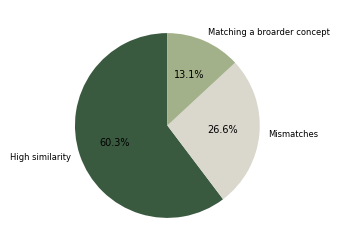

In [10]:
# plot a pie chart  
### Figure 2d

hits = sum(df_sorted['true_GO_term_sim_percentile'] >= 0.95)
# high_coverage

mismatches = len(df_sorted) - hits - high_coverage
labels = ['High similarity', 'Mismatches', 'Matching a broarder concept']
sizes = [hits, mismatches, high_coverage]
colors = ['#3a5a40','#dad7cd','#a3b18a']
fig, ax = plt.subplots(figsize=(3,3))
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
fig.savefig('figures/GPT4_GO_compare_stats_pie_chart.svg', bbox_inches='tight')


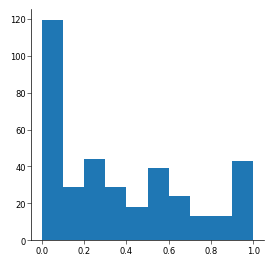

In [8]:
plt.figure(figsize=(3,3))
plt.hist(new_df['best_match_coverage'])

sns.despine()

In [14]:
# save the dataframe where the coverage is < 50%
mismatch_res = new_df[new_df['covered_by_best_match'] == False]

print(mismatch_res[mismatch_res['gpt_4_default Score Bin'] == 'High Confidence'].shape[0])

print(mismatch_res.shape)
mismatch_res.to_csv('data/GO_term_analysis/LLM_processed_selected_1000_go_terms_mismatch_subset.tsv', sep='\t')


112
(239, 11)


In [1]:
import pandas as pd
mismatch_res = pd.read_csv('data/GO_term_analysis/LLM_processed_selected_1000_go_terms_mismatch_subset.tsv', sep='\t')
mismatch_res['gpt_4_default Score Bin'].value_counts()

Medium Confidence    120
High Confidence      112
Low Confidence         6
Name not assigned      1
Name: gpt_4_default Score Bin, dtype: int64

## hypergeometric test res of all cases with best matching GO

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import mannwhitneyu
from matplotlib.ticker import FuncFormatter, MultipleLocator

cutoff = 0.05
df = pd.read_csv('data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')
# I need to remove rows that names are 'System of unrelated proteins'
df = df[df['gpt_4_default Name'] != 'System of unrelated proteins']
print(len(df))

top1_q = df['adj_pvals'].str.split('|').apply(lambda x: float(x[0]))
random_q = df['random_adj_pvals'].apply(lambda x: float(x))

# -log signifiance
# calculate -log(q)
eps = 1e-10
top1_q_log = -np.log10(top1_q+eps)
random_q_log = -np.log10(random_q+eps)
print(len(top1_q_log), len(random_q_log))
print('Median of top1_q_log: ', top1_q_log.median(), 'raw: ', top1_q.median())
print('Median of random_q_log: ', random_q_log.median(), 'raw: ', random_q.median())
significant = -np.log10(cutoff+eps)
print(significant)

fig, ax = plt.subplots(figsize=(3,3))

# add statistical test 

diff_p = mannwhitneyu(top1_q_log, random_q_log)[1]
print('p-value of Mann-Whitney U test: ', diff_p)

sns.violinplot(data=[top1_q_log, random_q_log], ax=ax, palette=['#FBF49C', '#B3B3B3'], inner='quartile', cut=0, split=True, width=1, linewidth=0.5)



def format_func(value, tick_number):
    if value >= 0:
        return f'$10^{{-{int(value)}}}$'
    else:
        return f'$10^{{{-int(value)}}}$'

ax.yaxis.set_major_formatter(FuncFormatter(format_func))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_ylabel("Significance of overlap (q-value)\nwith gene set query")

ax.axhline(significant, ls='--', color='red', alpha=0.5, label=f'q={cutoff}')
ax.legend(loc='upper right', fontsize = 6)
ax.set_xticklabels(["Best match GO name", "Random GO name"])
# Get the current x-limits
x_min, x_max = ax.get_xlim()

# Set new x-limits with more space on the left
ax.set_xlim(x_min - 0.005, x_max)

# Calculate the number of significant best match GOs
n_significant = (top1_q < cutoff).sum()

# Add text above the line showing the number of significant best match GOs
ax.text(0.5, significant + 0.5, f'N significant = {n_significant}', color='red', ha='center')

# add significance bar

max_y = max(max(top1_q_log), max(random_q_log))+0.03  # find the maximum y value with some gap
bar_height = max_y * 0.08  # set height of the bar to be 8% of the maximum y value
bar_start = 0 
bar_end = 1 

plt.plot([bar_start, bar_end], [max_y + bar_height, max_y + bar_height], color='black', linewidth = 0.5)  # plot horizontal line
# plt.plot([bar_start, bar_start], [max_y, max_y + bar_height], color='black')  # plot vertical line at start of the bar
# plt.plot([bar_end, bar_end], [max_y, max_y + bar_height], color='black')  # plot vertical line at end of the bar

# add asterisks or other text to indicate the level of significance
if diff_p < 0.0001:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "****", ha='center')
elif diff_p < 0.001:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "***", ha='center')
elif diff_p < 0.01:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "**", ha='center')
elif diff_p < 0.05:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "*", ha='center')
else:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "ns", ha='center')


sns.despine()

plt.savefig("figures/LLM_name_GO_term_bestmatch_logq_violin_cutoff005.svg", bbox_inches='tight')
plt.show()


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import mannwhitneyu
from matplotlib.ticker import FuncFormatter, MultipleLocator

cutoff = 0.05
df = pd.read_csv('data/GO_term_analysis/simrank_pval_LLM_processed_selected_1000_go_terms.tsv', sep='\t')

# also filter out thing with true_GO_term_sim_percentile >=0.95
df_filtered = df[df['true_GO_term_sim_percentile'] < 0.95]
print(len(df_filtered))
# for the bottom 500, how many have name 'System of unrelated proteins', remove
# because System of unrelated proteins will not have a best name that covers>50% of the genes
df_filtered = df_filtered[df_filtered['gpt_4_default Name']!= 'System of unrelated proteins']

df = df_filtered

top1_q = df['adj_pvals'].str.split('|').apply(lambda x: float(x[0]))
random_q = df['random_adj_pvals'].apply(lambda x: float(x))

# -log signifiance
# calculate -log(q)
eps = 1e-10
top1_q_log = -np.log10(top1_q+eps)
random_q_log = -np.log10(random_q+eps)
print(len(top1_q_log), len(random_q_log))
print('Median of top1_q_log: ', top1_q_log.median(), 'raw: ', top1_q.median())
print('Median of random_q_log: ', random_q_log.median(), 'raw: ', random_q.median())
significant = -np.log10(cutoff+eps)
print(significant)

fig, ax = plt.subplots(figsize=(3,3))

# add statistical test 

diff_p = mannwhitneyu(top1_q_log, random_q_log)[1]
print('p-value of Mann-Whitney U test: ', diff_p)

sns.violinplot(data=[top1_q_log, random_q_log], ax=ax, palette=['#FBF49C', '#B3B3B3'], inner='quartile', cut=0, split=True, width=1, linewidth=0.5)



def format_func(value, tick_number):
    if value >= 0:
        return f'$10^{{-{int(value)}}}$'
    else:
        return f'$10^{{{-int(value)}}}$'

ax.yaxis.set_major_formatter(FuncFormatter(format_func))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_ylabel("Significance of overlap (q-value)\nwith gene set query")

ax.axhline(significant, ls='--', color='red', alpha=0.5, label=f'q={cutoff}')
ax.legend(loc='upper right', fontsize = 6)
ax.set_xticklabels(["Best match GO name", "Random GO name"])
# Get the current x-limits
x_min, x_max = ax.get_xlim()

# Set new x-limits with more space on the left
ax.set_xlim(x_min - 0.005, x_max)

# Calculate the number of significant best match GOs
n_significant = (top1_q < cutoff).sum()

# Add text above the line showing the number of significant best match GOs
ax.text(0.5, significant + 0.5, f'N significant = {n_significant}', color='red', ha='center')

# add significance bar

max_y = max(max(top1_q_log), max(random_q_log))+0.03  # find the maximum y value with some gap
bar_height = max_y * 0.08  # set height of the bar to be 8% of the maximum y value
bar_start = 0 
bar_end = 1 

plt.plot([bar_start, bar_end], [max_y + bar_height, max_y + bar_height], color='black', linewidth = 0.5)  # plot horizontal line
# plt.plot([bar_start, bar_start], [max_y, max_y + bar_height], color='black')  # plot vertical line at start of the bar
# plt.plot([bar_end, bar_end], [max_y, max_y + bar_height], color='black')  # plot vertical line at end of the bar

# add asterisks or other text to indicate the level of significance
if diff_p < 0.0001:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "****", ha='center')
elif diff_p < 0.001:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "***", ha='center')
elif diff_p < 0.01:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "**", ha='center')
elif diff_p < 0.05:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "*", ha='center')
else:
    plt.text((bar_start + bar_end) / 2, max_y + bar_height, "ns", ha='center')


sns.despine()

# plt.savefig("figures/LLM_name_GO_term_bestmatch_logq_violin_cutoff005.svg", bbox_inches='tight')
plt.show()